# Top Motifs

##  What is a motif?

A time series motif is a group of well conserved subsequences in a time series. The minimum of the matrix profile corresponds to the first motif pair. This algorithm exploits the Matrix Profile and MASS distance to find the nearest neighbor subsequences for the top motif pairs.

A great explanation is found in https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf starting on slide 36.
## Load libraries

In [1]:
from matrixprofile import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

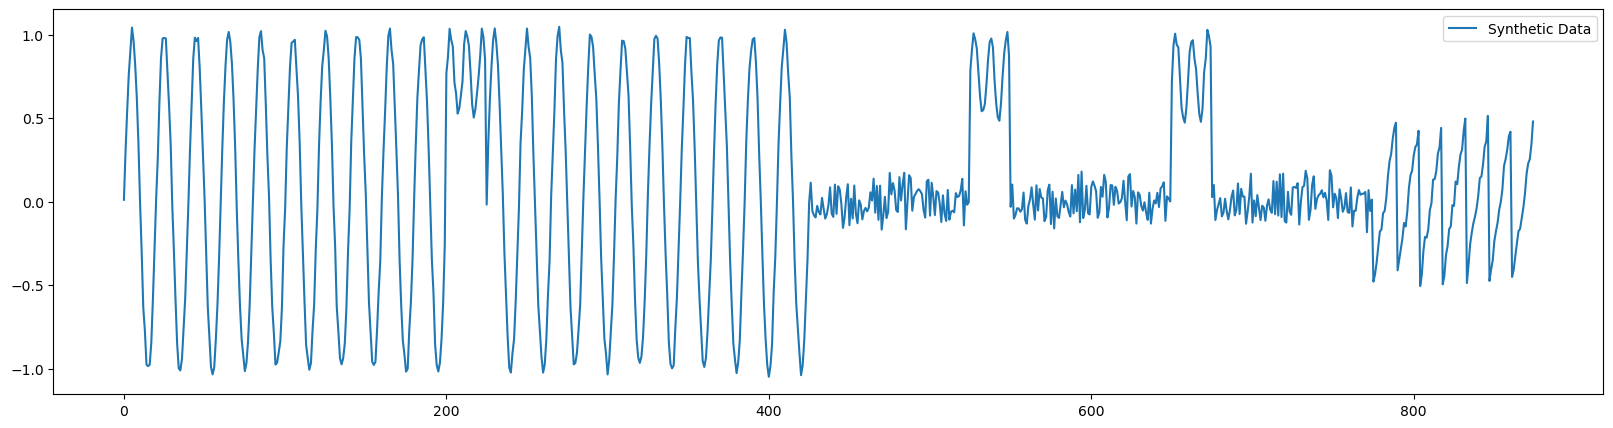

In [2]:
data = pd.read_csv('rawdata.csv')
pattern = data.data.values

#Plot data
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
legend = ax1.legend(loc='upper right')

## Calculate Matrix Profile and Motifs

Motif raggruppati: [[4, 24, 124, 249, 309, 329, 349], [15, 55, 95, 280, 320, 360], [46, 146, 251, 271]]
=== Intervalli Motif ===

● Motif Group 1:
  Segmento 1: [4, 35]
  Segmento 2: [24, 55]
  Segmento 3: [124, 155]
  Segmento 4: [249, 280]
  Segmento 5: [309, 340]
  Segmento 6: [329, 360]
  Segmento 7: [349, 380]

● Motif Group 2:
  Segmento 1: [15, 46]
  Segmento 2: [55, 86]
  Segmento 3: [95, 126]
  Segmento 4: [280, 311]
  Segmento 5: [320, 351]
  Segmento 6: [360, 391]

● Motif Group 3:
  Segmento 1: [46, 77]
  Segmento 2: [146, 177]
  Segmento 3: [251, 282]
  Segmento 4: [271, 302]


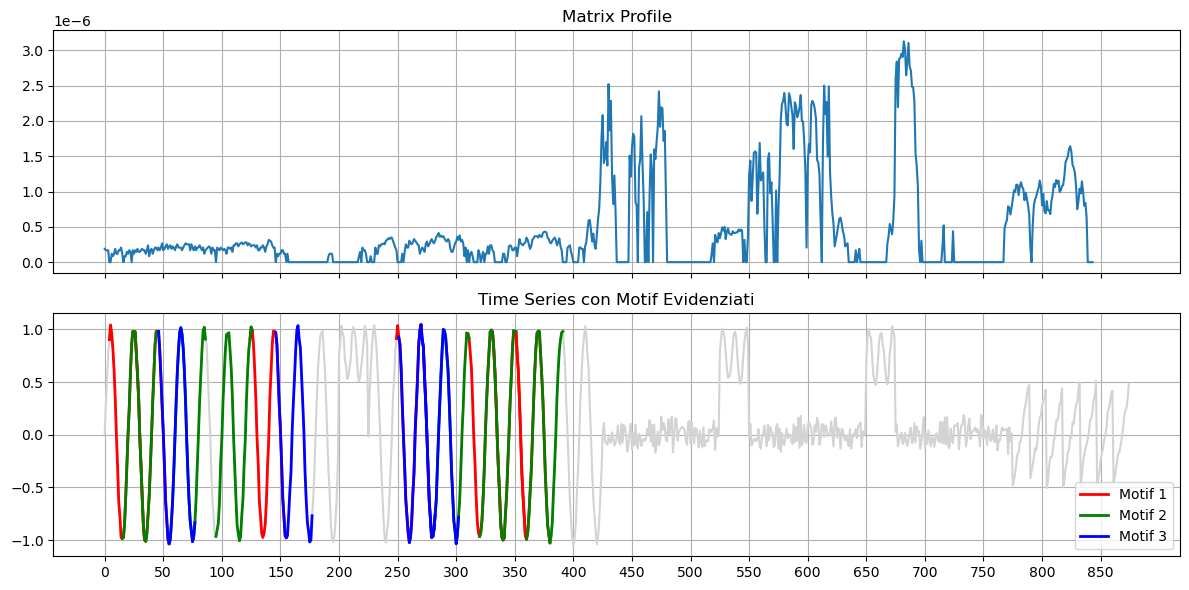

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def motifs_stmp(ts, mp, max_motifs=3, v=1, radius=2, n_neighbors=None, ex_zone=None):
    """
    Versione modificata della funzione motifs specifica per STMP.
    
    Parameters
    ----------
    ts : array-like
        Time series originale
    mp : tuple
        Matrix Profile (valori e indici)
    max_motifs : int
        Numero massimo di motif da trovare
    v : int
        Step size usato nel calcolo della Matrix Profile
    radius : float
        Fattore di espansione per cercare motif simili
    n_neighbors : int
        Numero massimo di vicini da considerare
    ex_zone : int
        Zona di esclusione
        
    Returns
    -------
    tuple
        (motifs, distances)
    """
    motifs = []
    distances = []
    
    try:
        mp_current1, mp_idx = mp
    except TypeError:
        raise ValueError("mp deve essere una tupla (matrix_profile, profile_index)")
    
    mp_current = np.copy(mp_current1)
    n = len(ts)
    m = n - len(mp_current) + 1
    
    if ex_zone is None:
        ex_zone = int(m / 2)
    
    for _ in range(max_motifs):
        # Trova il minimo nella matrix profile
        min_idx = np.nanargmin(mp_current)
        min_val = mp_current[min_idx]
        
        if np.isinf(min_val) or np.isnan(min_val):
            break
        
        # Aggiungi il motif alla lista
        motif_set = {min_idx}
        distances.append(min_val)
        
        # Trova l'indice del match più vicino
        match_idx = int(mp_idx[min_idx])
        if not np.isinf(mp_current[match_idx]):
            motif_set.add(match_idx)
        
        # Espandi il motif cercando vicini simili
        prof, _ = distanceProfile.massDistanceProfile(ts, min_idx, m, v, ts)
        
        
        # Applica zona di esclusione
        for idx in motif_set:
            _applyExclusionZone(prof, idx, ex_zone)
        
        # Cerca altri vicini simili
        sorted_idx = np.argsort(prof)
        neighbor_count = 0
        
        for idx in sorted_idx:
            if n_neighbors is not None and neighbor_count >= n_neighbors:
                break

            threshold = max(min_val * radius, 0.3) #altrimenti spesso min_val era 0 e non aggiornava
                
            if prof[idx] > threshold:
                break
                
            if not np.isinf(prof[idx]):
                motif_set.add(idx)
                neighbor_count += 1
                _applyExclusionZone(prof, idx, ex_zone)
        
        motifs.append(sorted(motif_set))
        
        # Applica zona di esclusione alla matrix profile
        for idx in motif_set:
            _applyExclusionZone(mp_current, idx, ex_zone)
    
    return motifs, distances

def _applyExclusionZone(prof, idx, zone):
    """Applica una zona di esclusione al profilo."""
    start = max(0, idx - zone)
    end = min(len(prof), idx + zone + 1)
    prof[start:end] = np.inf

def find_motifs_stmp(ts, m, v=1, max_motifs=3, radius=2, n_neighbors=None, ex_zone=None):
    """
    Trova i motif in una time series usando la Matrix Profile di STMP.
    """
    # Calcola la Matrix Profile con STMP
    mp = matrixProfile.stmp(ts, m, v)
    
    # Trova i motif usando la nostra funzione specifica
    motifs, distances = motifs_stmp(ts, mp, max_motifs=max_motifs, v=v, 
                                  radius=radius, n_neighbors=n_neighbors, 
                                  ex_zone=ex_zone)
    
    return motifs, distances, mp

def plot_motifs(ts, motifs, mp, m):
    """Visualizza i risultati con linee invece di rettangoli."""
    mp_values, mp_indices = mp
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Plot Matrix Profile
    if v==1:
        ax1.plot(mp_values)
        ax1.set_title('Matrix Profile')
        ax1.grid(True)
    else:
        # Creiamo un array di NaN per full length
        mp_full = np.full_like(mp_values, np.nan)
        valid_indices = np.arange(0, len(mp_values), v)

        # Copiamo i valori validi
        mp_full[valid_indices] = mp_values[valid_indices]

        # Sostituisci NaN con valore precedente per linea continua
        mp_filled = mp_full.copy()
        for i in range(1, len(mp_filled)):
            if np.isnan(mp_filled[i]):
                mp_filled[i] = mp_filled[i-1]
        ax1.plot(mp_filled)
        ax1.set_title('Matrix Profile')
        ax1.grid(True)
    
    # Plot Time Series con motif
    ax2.plot(ts, color="lightgrey")
    ax2.set_title('Time Series con Motif Evidenziati')
    ax2.grid(True)
    
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
    
    for i, motif_group in enumerate(motifs):
        color = colors[i % len(colors)]
        for idx in motif_group:
            # Estrai il segmento corrispondente al motif
            segment = ts[idx:idx+m]
            # Disegna il segmento con colore e spessore aumentato
            ax2.plot(range(idx, idx+m), segment, 
                    color=color, 
                    linewidth=2,
                    label=f'Motif {i+1}' if idx == motif_group[0] else None)
    
    ax2.set_xticks([i * 50 for i in range(0, 18)])
    ax2.legend()
    plt.tight_layout()
    plt.show()

def print_motif_ranges(motifs, m):
    print("=== Intervalli Motif ===")
    for i, group in enumerate(motifs):
        print(f"\n● Motif Group {i+1}:")
        for j, idx in enumerate(group):
            print(f"  Segmento {j+1}: [{idx}, {idx + m - 1}]")
    
# Parametri
m = 32
v = 1

# Trova i motif
motifs, distances, mp = find_motifs_stmp(
    ts=pattern,
    m=m,
    v=v,
    max_motifs=3,
    radius=1.2
)


print("Motif raggruppati:", motifs)


print_motif_ranges(motifs, m=32)

plot_motifs(pattern, motifs, mp, m)



c:\users\saran\onedrive\desktop\università\magistrale\time series analysis\project\matrixprofile-ts\matrixprofile\distanceProfile.py:67: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB,v).astype(complex)))


Motif raggruppati: [[2, 22, 42, 62, 122, 142, 162, 406], [2, 22, 42, 62, 82, 102, 122, 142, 162, 406], [20, 60, 100, 140, 180], [198, 218, 508]]
=== Intervalli Motif ===

● Motif Group 1:
  Segmento 1: [2, 33]
  Segmento 2: [22, 53]
  Segmento 3: [42, 73]
  Segmento 4: [62, 93]
  Segmento 5: [122, 153]
  Segmento 6: [142, 173]
  Segmento 7: [162, 193]
  Segmento 8: [406, 437]

● Motif Group 2:
  Segmento 1: [2, 33]
  Segmento 2: [22, 53]
  Segmento 3: [42, 73]
  Segmento 4: [62, 93]
  Segmento 5: [82, 113]
  Segmento 6: [102, 133]
  Segmento 7: [122, 153]
  Segmento 8: [142, 173]
  Segmento 9: [162, 193]
  Segmento 10: [406, 437]

● Motif Group 3:
  Segmento 1: [20, 51]
  Segmento 2: [60, 91]
  Segmento 3: [100, 131]
  Segmento 4: [140, 171]
  Segmento 5: [180, 211]

● Motif Group 4:
  Segmento 1: [198, 229]
  Segmento 2: [218, 249]
  Segmento 3: [508, 539]


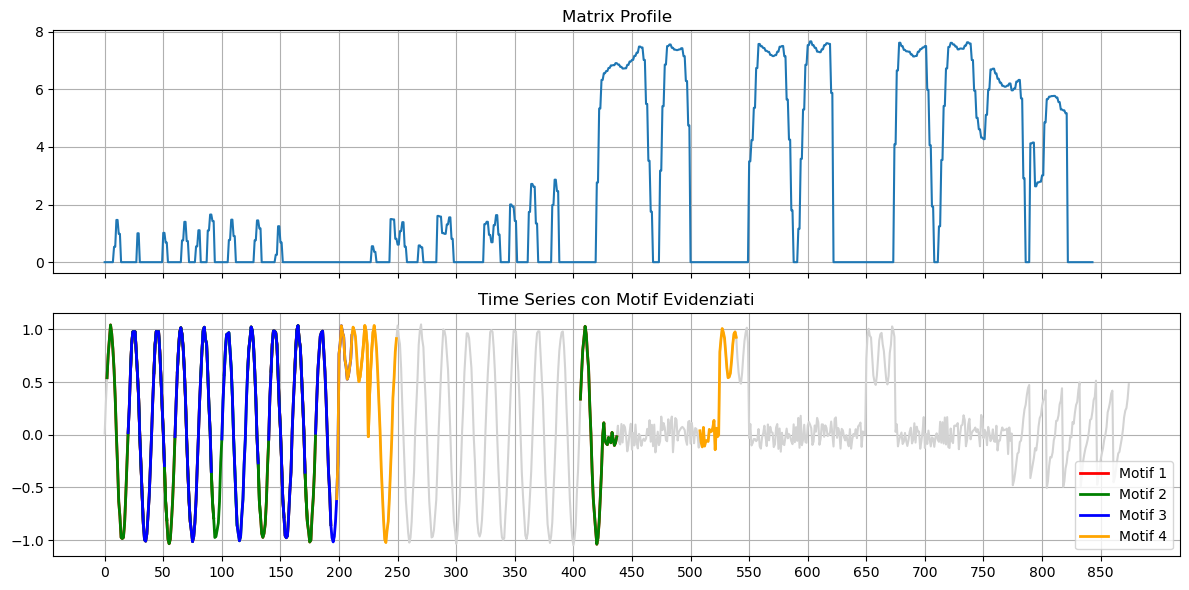

In [9]:
# Parametri
m = 32
v = 2

# Trova i motif
motifs, distances, mp = find_motifs_stmp(
    ts=pattern,
    m=m,
    v=v,
    max_motifs=4,
    radius=1.2
)


print("Motif raggruppati:", motifs)


print_motif_ranges(motifs, m=32)

plot_motifs(pattern, motifs, mp, m)


## `motifs.motifs`

### Parameters

 * `max_motifs`: stop finding new motifs once we have max_motifs
 * `radius`: For each motif found, find neighbors that are within `radius*motif_mp` of the first. 
 * `n_neighbors`: number of neighbors from the first to find. If it is None, find all.  
 * `ex_zone`: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If `ex_zone = 0`, only the found index is exclude, if `ex_zone = 1` then if `idx` is found as a motif `idx-1, idx, idx+1` are excluded.

### Returns
The function returns a tuple `(top_motifs, distances)` which are lists of the same length.

 * `top_motifs`: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances. 
 * `distances`: Minimum Matrix profile value for each motif set.

